In [243]:
from datetime import datetime

import os
from pathlib import Path
import subprocess
import warnings
import re
import pickle
import pandas as pd
import functools

import jax
import jax.numpy as jnp

from src.config.core import Config
from src.config.sampler import Sampler
from src.config.data import DatasetType
import src.dataset as ds
from src.models.tabular import FCN
import src.training.utils as train_utils
import src.inference.utils as inf_utils
import src.visualization as viz
from src.config.data import Task
from src.inference.evaluation import evaluate_bde
from src.types import ParamTree

from matplotlib import pyplot as plt
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

import numpy as np

from tqdm import tqdm

In [244]:
def load_results(path, type, ms, seeds, exploration_steps):
    df = pd.DataFrame(columns=['m', 'lppd', 'rmse', 'time', 'seed'])
    nan_counts = []
    for i, m in enumerate(ms):
        nan_count = 0
        for seed in seeds:
            if type == 'parallel':
                results_dir = f'{path}/{m}x1_constant_{exploration_steps}+500_seed{seed+i}'
            else:
                results_dir = f'{path}/1x{m}_constant_{exploration_steps}+500_seed{seed+i}'
            # results_dir = f'results/bike2/parallel_constant_{n}_seed{seed}'
            # results_dir = f'results/bike9/sequential_cyclical_{n}_seed{seed+i}'
            metrics_dir = f'{results_dir}/eval_metrics.pkl'
            samples_dir = f'{results_dir}/samples'
            tree_path = f'{results_dir}/tree'
            if not os.path.exists(metrics_dir):
                nan_count += 1
                print(f'Skipping {results_dir} - does not exist')
                samples = train_utils.load_samples_from_dir(samples_dir, tree_path=tree_path)
                samples_nan = jax.tree.map(lambda x: jnp.isnan(x), samples)
                print(f'Found NaN in samples: {samples_nan}')
                break
            with open(f'{results_dir}/eval_metrics.pkl', 'rb') as f:
                eval_metrics = pickle.load(f)
            with open(f'{results_dir}/samples/info.pkl', 'rb') as f:
                info = pickle.load(f)
            curr_lppd = eval_metrics['lppd']
            curr_rmse = eval_metrics['rmse']
            # lppd.append(curr_lppd)
            # rmse.append(curr_rmse)
            # times.append(info['total_time'])
            df = pd.concat([df, pd.DataFrame({
                'm': [m],
                'lppd': [curr_lppd],
                'rmse': [curr_rmse],
                'time': [info['total_time']],
                'seed': [seed+i]
            })], ignore_index=True)
        nan_counts.append(nan_count)

    print(f'Nan counts: {nan_counts}')

    df = df.groupby('m').agg({
        'lppd': ['mean', 'std'],
        'rmse': ['mean', 'std'],
        'time': ['mean', 'std'],
        # 'seed': 'count'
    }).reset_index().rename(columns={'index': 'm'})

    return df

In [245]:
ms=np.array([2, 4, 6, 8, 10, 12])
seeds = [0, 42, 221, 476, 1453, 1644, 1840, 1973, 2025, 2100]
res_parallel_5k = load_results('results/bike8', 'parallel', ms=ms, seeds=seeds, exploration_steps=5000)
res_parallel_2k = load_results('results/bike8', 'parallel', ms=ms, seeds=seeds, exploration_steps=2000)
res_sequential_2k = load_results('results/bike8', 'sequential', ms=ms, seeds=seeds, exploration_steps=2000)
res_sequential_5k = load_results('results/bike8', 'sequential', ms=ms, seeds=seeds, exploration_steps=5000)
res_parallel_2k

/tmp/ipykernel_13667/1050273760.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({
/tmp/ipykernel_13667/1050273760.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({
/tmp/ipykernel_13667/1050273760.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the

Nan counts: [0, 0, 0, 0, 0, 0]
Nan counts: [0, 0, 0, 0, 0, 0]
Nan counts: [0, 0, 0, 0, 0, 0]
Nan counts: [0, 0, 0, 0, 0, 0]


/tmp/ipykernel_13667/1050273760.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({


m      lppd                rmse                 time          
           mean       std      mean       std       mean       std
0   2  0.504015  0.025989  0.260903  0.008234   8.027276  0.763302
1   4  0.528785  0.035105   0.25437  0.003156  11.256700  0.263808
2   6  0.546247  0.036026  0.251747  0.010320  14.641169  0.348427
3   8  0.557306  0.029010  0.249607  0.008145  18.113092  0.574211
4  10  0.551664  0.021646  0.254935  0.006697  20.727204  0.949022
5  12   0.55038  0.028540  0.253562  0.006090  24.469014  1.802065

In [246]:
def plot_comparison(res_parallel, res_sequential):
    ms = res_parallel['m'].to_numpy()
    mean_lppd_parallel = res_parallel['lppd']['mean'].to_numpy()
    std_lppd_parallel = res_parallel['lppd']['std'].to_numpy()
    mean_rmse_parallel = res_parallel['rmse']['mean'].to_numpy()
    std_rmse_parallel = res_parallel['rmse']['std'].to_numpy()

    mean_lppd_sequential = res_sequential['lppd']['mean'].to_numpy()
    std_lppd_sequential = res_sequential['lppd']['std'].to_numpy()
    mean_rmse_sequential = res_sequential['rmse']['mean'].to_numpy()
    std_rmse_sequential = res_sequential['rmse']['std'].to_numpy()

    fig, axs = plt.subplots(figsize=(6.3, 6.3/2), ncols=2)
    axs[0].errorbar(ms+0.1, mean_lppd_parallel, yerr=std_lppd_parallel, fmt='s--', label='parallel', color='blue')
    axs[0].errorbar(ms-0.1, mean_lppd_sequential, yerr=std_lppd_sequential, fmt='s--', label='sequential', color='red')
    axs[0].set_ylabel('LPPD')
    axs[0].set_xlabel('Number of chains/cycles')
    axs[1].errorbar(ms+0.1, mean_rmse_parallel, yerr=std_rmse_parallel, fmt='s--', label='parallel', color='blue')
    axs[1].errorbar(ms-0.1, mean_rmse_sequential, yerr=std_rmse_sequential, fmt='s--', label='sequential', color='red')
    axs[1].set_ylabel('RMSE')
    axs[1].set_xlabel('Number of chains/cycles')

    axs[0].set_xticks(ms)
    axs[0].set_xticklabels(ms)
    axs[1].set_xticks(ms)
    axs[1].set_xticklabels(ms)

    # Remove duplicate labels in the legend
    handles, labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
    fig.tight_layout()

    return fig, axs


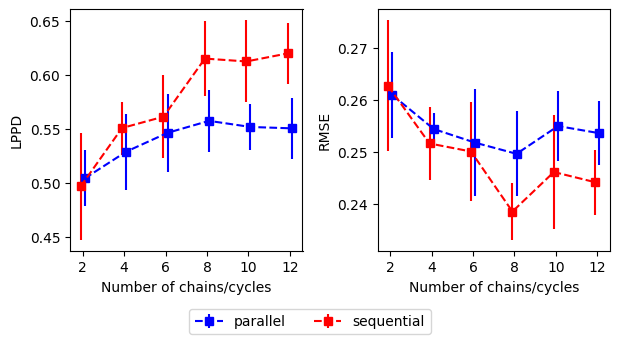

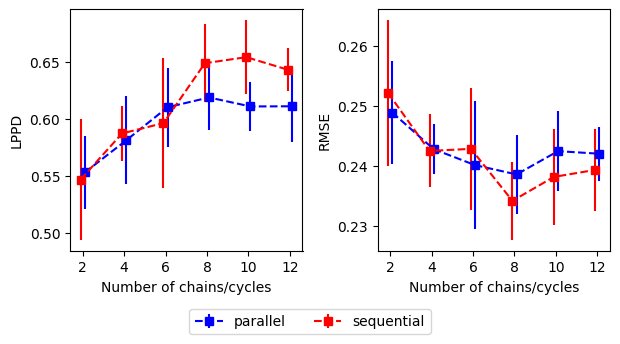

In [247]:
fig, axs = plot_comparison(res_parallel_2k, res_sequential_2k)
# plt.savefig('../ba/images/parallel_vs_sequential_constant_2k.pdf', bbox_inches='tight')

fig, axs = plot_comparison(res_parallel_5k, res_sequential_5k)
# plt.savefig('../ba/images/parallel_vs_sequential_constant_5k.pdf', bbox_inches='tight')

In [248]:
res_parallel_2k['lppd']

,mean,std
0,0.504015,0.025989
1,0.528785,0.035105
2,0.546247,0.036026
3,0.557306,0.029010
4,0.551664,0.021646
5,0.55038,0.028540


In [334]:
def combine_mean_std(res):
    combined = res.copy()
    combined.columns = combined.columns.map("_".join)
    for col in ['lppd', 'rmse', 'time']:
        for suffix in ['mean', 'std']:
            name = f'{col}_{suffix}'
            combined[name] = combined[name].astype("float64").map(lambda x: f'{x:.3f}')
        combined[col] = combined[f'{col}_mean'].astype(str) + r' $\pm$ ' + combined[f'{col}_std'].astype(str)
    return combined[["m_", "lppd", "rmse", "time"]].rename(columns={'m_': 'm'})

def full_performance_table(res_par, res_seq, fn="tmp.tex"):
    res_par = combine_mean_std(res_par)
    res_seq = combine_mean_std(res_seq)
    m = r'$M$'
    lppd = r'LPPD ($\uparrow$)'
    rmse = r'RMSE ($\downarrow$)'
    header = pd.MultiIndex.from_tuples([
        (m, ''),
        (lppd, 'parallel'),
        (lppd, 'sequential'),
        (rmse, 'parallel'),
        (rmse, 'sequential'),
        # ('time', 'parallel'),
        # ('time', 'sequential')
    ])
    df = pd.DataFrame(columns=header)
    df[(m, '')] = res_par['m']
    df[(lppd, 'parallel')] = res_par['lppd']
    df[(lppd, 'sequential')] = res_seq['lppd']
    df[(rmse, 'parallel')] = res_par['rmse']
    df[(rmse, 'sequential')] = res_seq['rmse']
    with open(fn, 'w') as f:
        df.to_latex(
            f,
            index=False,
            column_format='c' * len(header),
            escape=False,
            multicolumn=True,
            multicolumn_format='c',
        )

full_performance_table(res_parallel_2k, res_sequential_2k, fn="tmp_2k.tex")
full_performance_table(res_parallel_5k, res_sequential_5k, fn="tmp_5k.tex")

In [ ]:

# df[('time', 'parallel')] = res_par['time']
# df[('time', 'sequential')] = res_seq['time']

# df.style.to_latex("tmp.tex")
df.to_latex("tmp.tex", index=False, column_format='c'*7, escape=False, multicolumn=True, multicolumn_format='c')

In [323]:
# more quantitative comparison
df = pd.DataFrame({
    r'$M$': res_parallel_2k['m'],
    'LPPD (2k)': res_sequential_2k['lppd']['mean'] - res_parallel_2k['lppd']['mean'],
    'LPPD (5k)': res_sequential_5k['lppd']['mean'] - res_parallel_5k['lppd']['mean'],
    'RMSE (2k)': res_sequential_2k['rmse']['mean'] - res_parallel_2k['rmse']['mean'],
    # '2k_runtime': res_sequential_2k['time']['mean'] - res_parallel_2k['time']['mean'],
    'RMSE (5k)': res_sequential_5k['rmse']['mean'] - res_parallel_5k['rmse']['mean'],
    # '5k_runtime': res_sequential_5k['time']['mean'] - res_parallel_5k['time']['mean']
})
summary = df.agg(["mean"])
# "average" of m is meaningless
df = pd.concat([df, summary])
df

,$M$,LPPD (2k),LPPD (5k),RMSE (2k),RMSE (5k)
0,2.0,-0.007473,-0.006168,0.00173,0.003251
1,4.0,0.021886,0.006059,-0.002776,-0.000302
2,6.0,0.014949,-0.013922,-0.001695,0.002713
3,8.0,0.05771,0.030045,-0.011077,-0.004399
4,10.0,0.060678,0.043234,-0.008824,-0.004294
5,12.0,0.069436,0.032082,-0.009411,-0.002691
mean,7.0,0.036198,0.015222,-0.005342,-0.000954


In [324]:
formatter = {
    'LPPD (2k)': lambda x: f'{x:.3f}',
    'LPPD (5k)': lambda x: f'{x:.3f}',
    'RMSE (2k)': lambda x: f'{x:.3f}',
    'RMSE (5k)': lambda x: f'{x:.3f}',
    r'$M$': lambda x: f'{int(x)}' if x != 7 else 'Average',
}
df.to_latex("tmp_diff.tex", index=False, formatters=formatter, column_format='rrrrr')

In [17]:
pd.DataFrame({
    'm': res_parallel_5k['m'],
    'mean_time_parallel': res_parallel_5k['time']['mean'],
    'std_time_parallel': res_parallel_5k['time']['std'],
    'mean_time_sequential': res_sequential_5k['time']['mean'],
    'std_time_sequential': res_sequential_5k['time']['std']
})

,m,mean_time_parallel,std_time_parallel,mean_time_sequential,std_time_sequential
0,2,16.079952,0.333683,13.912291,0.663135
1,4,22.708983,0.987525,26.775873,1.495539
2,6,29.048546,1.100947,40.970220,1.284977
3,8,36.891613,1.190366,54.491716,1.702522
4,10,44.237754,1.328637,67.913778,1.822772
5,12,50.626534,1.486950,81.283531,3.115033


        mean       std
0  16.079952  0.333683
1  22.708983  0.987525
2  29.048546  1.100947
3  36.891613  1.190366
4  44.237754  1.328637
5  50.626534  1.486950
        mean       std
0  13.912291  0.663135
1  26.775873  1.495539
2  40.970220  1.284977
3  54.491716  1.702522
4  67.913778  1.822772
5  81.283531  3.115033


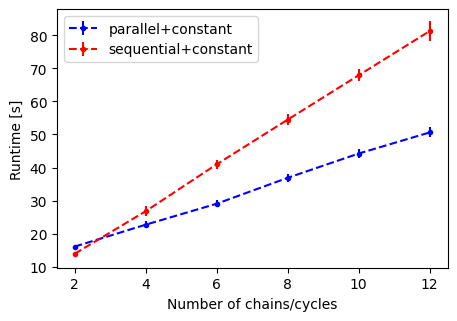

In [ ]:
# runtime
fig, ax = plt.subplots(figsize=(0.8*6.3, 0.8*6.3/3*2))
# ax.plot(ms, res_parallel_5k['time']['mean'], 'o--', label='parallel', color='blue')
# ax.plot(ms, res_sequential_5k['time']['mean'], 'o--', label='sequential', color='red')
ax.errorbar(ms, res_parallel_5k['time']['mean'], yerr=np.asarray(res_parallel_5k['time']['std']), fmt='o--', label='parallel+constant', color='blue', markersize=3)
ax.errorbar(ms, res_sequential_5k['time']['mean'], yerr=np.asarray(res_sequential_5k['time']['std']), fmt='o--', label='sequential+constant', color='red', markersize=3)
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Number of chains/cycles')
plt.legend(loc='upper left')
plt.savefig('../ba/images/parallel_vs_sequential_constant_5k_runtime.pdf', bbox_inches='tight')

In [109]:
std_times_parallel
std_times_sequential

[0.062129106379375555,
 0.3923627464537395,
 0.2984619072943373,
 0.6236271358990868,
 0.7588262985238265,
 1.392467000869469]

### Cycle length

In [66]:
def evaluate_bde_from_file(
    results_dir: Path,
    samples: ParamTree | None = None,
    cycle: int | None = None,
    chain: int | None = None,
    batch_size: int | None = None
):
    # """Evaluate BDE from a file."""
    if samples is None:
        sample_path = results_dir / 'samples'
        tree_path = results_dir / 'tree'
        samples = train_utils.load_samples_from_dir(sample_path, tree_path)

    config = Config.from_yaml(results_dir / 'config.yaml')
    n_samples = inf_utils.count_samples(samples)
    n_cycles = config.training.sampler.scheduler_config.parameters['n_cycles']
    n_chains = inf_utils.count_chains(samples)

    n_samples_per_cycle = n_samples // n_cycles

    if cycle is not None:
        assert 0 <= cycle < n_cycles, f'Cycle index {cycle} must be between 0 and {n_cycles}-1'
        samples = jax.tree.map(
            lambda x: x[:, cycle * n_samples_per_cycle : (cycle+1) * n_samples_per_cycle],
            samples
        )
    if chain is not None:
        assert 0 <= chain < n_chains, f'Chain index {chain} must be between 0 and {n_chains}-1'
        samples = jax.tree.map(
            lambda x: x[chain, ...][None, ...], # always preserve the chain dimension
            samples
        )

    # print(jax.tree.map(lambda x: x.shape, samples))

    module = config.get_flax_model()
    loader = ds.TabularLoader(
        config.data,
        rng=config.jax_rng,
        target_len=config.data.target_len
    )

    features = loader.test_x # (B x F)
    labels = loader.test_y # (B x T)

    metrics = {}
    logits, metrics = evaluate_bde(
        params=samples, # type: ignore
        module=module,
        features=features,
        labels=labels,
        task=config.data.task,
        batch_size=batch_size,
        verbose=False,
        metrics_dict=metrics,
        nominal_coverages=[0.5, 0.75, 0.9, 0.95],
        per_chain=False
    )

    return logits, metrics

In [4]:
from IPython.display import clear_output
dir = Path('results/bike10')

# os.listdir(results_dir)
pattern = r'1x12_constant_(\d+)\+(\d+)_10_seed(\d+)'
n_cycles = 12
all_metrics = []
# exploration_lengths = [2000, 3000, 4000, 5000, 6000]
all_metrics = []
for result in sorted(os.listdir(dir)):
    match = re.match(pattern, result)
    if not match:
        continue
    results_dir = dir / result
    exploration_steps = int(match.group(1))
    samples = train_utils.load_samples_from_dir(
        results_dir / 'samples',
        tree_path=results_dir / 'tree'
    )
    for cycle in range(n_cycles):
        print(f'Evaluating cycle {cycle} in {results_dir}')
        logits, metrics = evaluate_bde_from_file(
            results_dir=results_dir,
            samples=samples,
            cycle=cycle,
            chain=None,
            batch_size=None
        )
        clear_output(wait=True)
        all_metrics.append({
            'cycle': cycle + 1,  # 1-indexed for plotting
            'exploration_steps': exploration_steps,
            'lppd': metrics['lppd'],
            'rmse': metrics['rmse']
        })

df = pd.DataFrame(all_metrics)
print(df)

     cycle  exploration_steps        lppd        rmse
0        1               2000   0.4899946   0.2515205
1        2               2000  0.56510115  0.23893864
2        3               2000   0.5886327  0.23316388
3        4               2000  0.60376567  0.22930914
4        5               2000  0.60704386  0.22930907
..     ...                ...         ...         ...
415      8               8000   0.5361827  0.25653842
416      9               8000   0.4966121  0.25839975
417     10               8000   0.5210781  0.25570953
418     11               8000   0.5551425  0.25627956
419     12               8000   0.5488699  0.25646514

[420 rows x 4 columns]


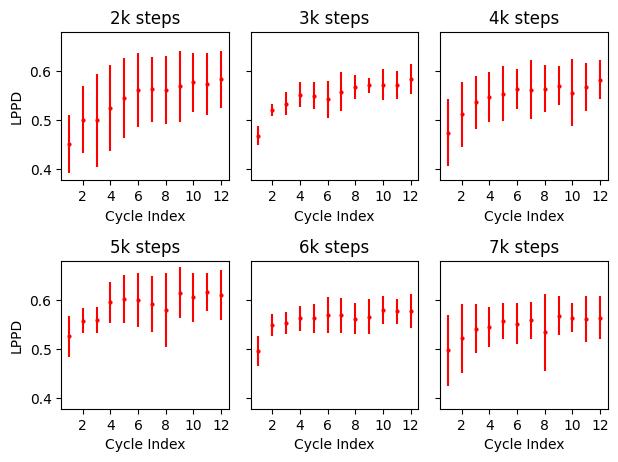

In [5]:
df_agg = df.groupby(['exploration_steps', 'cycle']).agg({
    'lppd': ['mean', 'std'],
    'rmse': ['mean', 'std']
})
# df_agg

fig, axs = plt.subplots(2, 3, figsize=(6.3, 6.3/4*3), sharey='all')
for i, exploration_steps in enumerate([2000, 3000, 4000, 5000, 6000, 7000]):
    ax = axs[i // 3, i % 3]
    df_subset = df_agg.xs(exploration_steps, level='exploration_steps')
    cycles = df_subset.index.get_level_values('cycle')
    lppd_means = df_subset['lppd']['mean']
    lppd_stds = df_subset['lppd']['std']
    # rmse_means = df_subset['rmse']['mean']
    # rmse_stds = df_subset['rmse']['std']

    # ax.plot(cycles, lppd_means, 'o--', color='red')
    ax.errorbar(cycles, lppd_means, yerr=lppd_stds, fmt='o', color='red', markersize=2)
    # ax.errorbar(cycles, rmse_means, yerr=rmse_stds, fmt='o--', label='RMSE', color='blue')
    
    ax.set_title(f'{exploration_steps//1000}k steps')
    ax.set_xlabel('Cycle Index')
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    # ax.set_ylabel('Metric Value')
    # ax.legend()

axs[0,0].set_ylabel('LPPD')
axs[1,0].set_ylabel('LPPD')
fig.tight_layout()
fig.savefig('../ba/images/ablation_cycle_length.pdf', bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(8, 4))
# for exploration_steps in [2000, 3000, 4000, 5000, 6000, 7000, 8000]:
#     df_subset = df_agg.xs(exploration_steps, level='exploration_steps')
#     cycles = df_subset.index.get_level_values('cycle')
#     lppd_means = df_subset['lppd']['mean']
#     lppd_stds = df_subset['lppd']['std']

#     ax.errorbar(cycles, lppd_means, yerr=lppd_stds, fmt='o--', label=f'{exploration_steps} steps')

# ax.set_xlabel('Cycle index')
# ax.set_ylabel('LPPD')
# ax.set_title('LPPD per cycle')
# plt.legend(title='Exploration Steps')